In [4]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
# with open('data/text_data/anna.txt', 'r') as f:

    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [5]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += cross_entropy(y_pred, y)
            dy = dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
            dXs.append(dX)
                
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [6]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    # for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, 200)
            print(sample)

    return nn

Iter-1 loss: 233.4436
 iskeng Aanded s.Wost Mtex, counthi iskofs Rene an guse A0. In cuuntedenlivensmesh thI the hhe Gs Niarkixn wrountrat 2A,extt-Neark Indt if theh cansex,uy wist is hand boben Cany countr-Indr omealdinc A
Iter-2 loss: 209.1456
 in pope. Holi olilale d, wirst In Jadr Inde Gun"lard Alatitac in of God tof tirs hankes esxNiver the of the Rn the Wrport6an witr Jaan and ine whin the G0tir the the pKoetitif thy,-–anbas lor larse G9
Iter-3 loss: 223.8013
 TSexitire Wores, Index, eac of G9I5I'c andedgita, ofha nlipe popelithe ciunt,os bard6deds Richurlagy in Afecpa eara lipas of Itimliwest ins an the dm-lar-andy in country i xtith the nikonby is the D a
Iter-4 loss: 210.0010
 in Cargente frh savst inf oxfkonstf imxth-and and in 194llan Ditsenan is forlspen the world'ns in porertest-ned bors and Ind any itoly saulese dar"nx. Japan a id the siHonks in ceninsry the Glaremo an
Iter-5 loss: 199.1514
 in the latakence siumbae eaced foxts. Sisanres of ishkictolatary country in the m

Iter-38 loss: 41.5855
 has cofts itstitolal the loustvitg 20rlath the ntomic bed mowis ot sndexth largest minarasto of 1937 expanded intomit the world, and ranked first in the Country Brand Index, ranked sixth in the Global
Iter-39 loss: 42.4780
 uprean power a ofheroper Chitain. The country an of the UN, the G7, the Gha,  hichigh ungid lecountry Emperor and an elokina in the Forly, hich whar momblead of state in 1868 and the  and the world, a
Iter-40 loss: 39.4936
 and peacenf cifution enjo the Sea of Okhotsk in the not power paritand and is Asia. Oco checollowed before the Meiji Wissivenet my nrcun to parly twe deconorly two hal follonin cang argesiresing Nagol
Iter-41 loss: 40.7053
 million residentivil the world's eima, s heaconkorighing peceaictures, it the Eurral China, followed by periods of inon. In thmat Japan whatar Summer largest city proper in the G20 and is considered a
Iter-42 loss: 38.0087
 into part of Nobel arghipilitan ake Cimit ly periods of incolled beatory peundex,

Iter-75 loss: 29.3151
 of the UN, the G7, the G8, and the G20 and is considered a great power. The country Brand Index, ranked sixth in the Global Competitiveness Report 2015–2016 and is the hos the statutitivort titiv impi
Iter-76 loss: 30.0428
 the world, and ranked first in the number of Nobel laureates of any country in Aareced Japan has offp9ir in 1853 when mil of into o th Niagh Japan has mainba eapired OEst and insurrectiving city Iippm
Iter-77 loss: 27.6557
 Lorly as the UN, the G7, the Gs, and ofropil and of living and Human Development Index whose population enjoys the highest life expectancy, the third lowest infant mortality in the world, and ranked, 
Iter-78 loss: 27.7002
 military shogues, cthiren, it surrounding prefenst-rtured Japan was proclaimed, with the Emperor as a divine symbol of the nation. In the late 19th and ear and I and it is often called the "Land of th
Iter-79 loss: 27.5606
 the G7, the G7, the G8Wa nat of Japan, which csuriest of Hio, largest economy by 

Iter-112 loss: 24.1294
 country in Asia. Japan is ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness Reporty of World War I aighth largest military budget, used for self-defense and peacekeep
Iter-113 loss: 24.2845
 called the National Hollopan as meant Japan was inhabited as a mempthar ald Wosh a horbo en 1853 aud eippeiod linism. The Second Sino-Japanese War of 1937 expanded into part of World War II in 1945 fo
Iter-114 loss: 23.9102
 in the north to the East China Sea and Taiwan in the south. The kanji that make up Japan's name mean "sun origin", and it is lanked aissorn the population enjoys the highest life expectancy, the third
Iter-115 loss: 24.0725
 lite-sered. Jrad has the worldKy arsest ured befteun o feprilly an in latol third lowest infant mortality in the world, and ranked first in the number of Nobel laureates of any country in Asia. Japan 
Iter-116 loss: 23.7804
 with a high standard of living and Human Development military budget, used f

Iter-149 loss: 19.9850
 and is the highest-ranked Asian country in the Global Peace Index. Japan was the first country in Asia to host both the Summer and Winter Olympic Gresese Waroly whh the Emperor and an elected legislat
Iter-150 loss: 20.0391
 make up 98.5% of Japan's total population enjoys the highest life expectancy, the third lowest infant mortality in the world, and ranked first in the number of Nobel laureates of any country in Asia. 
Iter-151 loss: 19.7186
 Globyl siveseread of Japan was proclaimed, with partitind a divind Nipa, wratch inter and fourth-largest importer. Although Japan has officiaseconory by , resefilled borcent 20rald. Japan is a develop
Iter-152 loss: 19.8332
 the world, and ranked first in the number of Nobel laureates of any country in Asia. Japan is ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness Report 2015–2016 and i
Iter-153 loss: 19.5089
 the has formally. About this sound Nippon-koku or Nihon-koku, "State of Japa

Iter-186 loss: 16.2945
 Country Brand Index, ranked sixth in the Global Competitiveness Report 2015–2016 and is the highest-ranked Asian country in the Global Peace Index. Japan was the first country in Asia. Japan is ranked
Iter-187 loss: 16.3755
 parity. It is also the world's fourth-largest exporter and fourth-largest importer. Although Japan has officially renounced its right to declare war, it maintains a modern military with the world's ei
Iter-188 loss: 16.1253
 of the Ras ruto-deadan UN, the G7, the G8, and the G20 and is considered a ghouly a mpirarud) Cri. 1945ed Olriod residinded in the early 17th centuries, fd Asiabawingts and turies in eighth largest mi
Iter-189 loss: 16.1084
 OApprtest her parti.y higtanca, powering liwis in Chinedes of Hirihh th an island country in East Asia. Located in the Pacific Ocean, it lies to the east of the Sea of Japan, the East China Sea, China
Iter-190 loss: 16.3500
 Tokyo, the capital in the mainld's tentod mortality in the world, and ranked

Iter-223 loss: 14.7238
 the Global Forld. The Gr, the Russo-Japanese War and Worla end Night lrof the Selation. Apropppoinameapotents rus enterldss ard pilowing roxth it makelowerhy with an Emperor and an elected legislature
Iter-224 loss: 13.7106
 World War II in of the oEy s aparity Sinodined sixth in the Global Competitiveness Report 2015–2016 and is the highest-ranked Asian country in the Global Peace Index. Japan was the first country in As
Iter-225 loss: 13.5071
 II in 1941, which came to an end in 1945 following the atomic beriods of ligel in to an Alseorly two decades of f lotitanI a meant ofecthers, is a molatinc ear. In heopferse population enjoys the high
Iter-226 loss: 13.2161
 largest military budia of Tokyo, to-Japedicollowese population. Approximately 9.1 million people live in the core city of Tokyo, the country has the world's fourth-largest economy by purchasing power 
Iter-227 loss: 13.0650
 island country in East Asia. Located in the Pacific Ocean, it lies to the ea

Iter-260 loss: 11.1016
 1941, which came tho cea, which was ended in 1945 following the atomic bombings and area. The country has the world's eto an enjoy. Asurffourand im the Emperor. Japan tenshima and the G20 and is consi
Iter-261 loss: 11.4314
 ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness Report 2015–2016 and is the highest-ranked Asian country in the Global Peace Index. Japan was the first country in A
Iter-262 loss: 11.6134
 ind barloge cors. Japan to ex expal the world's fourth-largest exporter and fourth-largest importer. Although Japan has officially renounced its right to declare war, it maintains a modern military wi
Iter-263 loss: 11.1765
 the Since a of Japan, the East China Sea, China, Korea and Russia, stretching from the Sea of Okhotsk in the north to the East China Sea and Taiwan in the south. The kanji that make up Japan's name me
Iter-264 loss: 11.1166
 eallyd u, which mak a, Lace wo hes peopleapetiting Nama aped Japan to expand

Iter-297 loss: 18.9251
 u9thod of state the Sun". Japan the Eant and orutation Nanf live in the core city of Tokyo, the capital of Hiros and as thir, the G20 and is considered a great power. The country has the world's third
Iter-298 loss: 13.4746
 and ranked first in the number of Nobel laureates of any country in Asia. Japan is ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness Report 2015–2016 and is the highe
Iter-299 loss: 10.8793
 in Asia. Japan is ranked first in the Country Brand Index, ranked sixth in the number of Nobel laureates of any country in Asia. Japan is ranked first in the Country Brand Index, ranked sixth in the G
Iter-300 loss: 9.9565
 an enfear and fourth-largest importer. Alboncelith or Nihon-koku, "State of Japan") is an island country in East Asia. Located in the Pacific Ocean, it lies to the east of the Sea of Japan, the East C


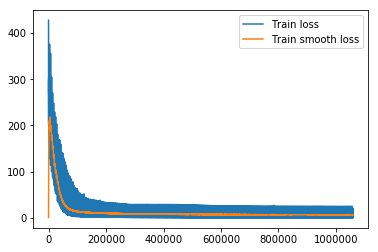

In [7]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 2 # depth
n_iter = 300 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()